# Inter-Model Evaluation Analysis

This notebook performs aggregate inter-model evaluation analysis across all jobs in `data/local/`.

**Analysis Scope:**
- Auto-discovers all jobs in data/local/
- Aggregates metrics across all jobs
- Provides detailed tables and visualizations
- Focuses on model comparison, field types, pass trends, and low agreement fields

**Generated:** (run notebook to see timestamp)

## 1. Setup & Imports

In [78]:
# Data processing
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from pathlib import Path
import json
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation modules
import sys
sys.path.append(str(Path.cwd().parent))

from src.evaluation.evaluator import evaluate_job
from src.evaluation.models import JobEvaluation, FieldEvaluation, ModelPerformance
from src.evaluation.loader import MODEL_NAMES
from src.evaluation.field_registry import PASS1_FIELDS, PASS2_FIELDS, PASS3_FIELDS

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✓ All imports successful")
print(f"Analysis started at: {datetime.now()}")

✓ All imports successful
Analysis started at: 2025-12-08 00:21:23.661979


## 2. Data Discovery & Loading

In [79]:
def discover_and_evaluate_jobs(base_path=None):
    """
    Auto-discover and evaluate all jobs in data/local directory.
    
    Returns:
        tuple: (list of JobEvaluation objects, metadata dict)
    """
    # Use project root relative path
    if base_path is None:
        base_path = Path(__file__).parent.parent / "data" / "local" if "__file__" in dir() else Path.cwd().parent / "data" / "local"
    
    data_path = Path(base_path)
    
    if not data_path.exists():
        raise FileNotFoundError(f"Data path not found: {data_path}")
    
    # Discover job directories
    job_dirs = [d for d in data_path.iterdir() if d.is_dir() and d.name.isdigit()]
    job_ids = sorted([d.name for d in job_dirs])
    
    print(f"Found {len(job_ids)} job(s): {job_ids}")
    
    # Evaluate each job
    job_evals = []
    failed_jobs = []
    
    for job_id in job_ids:
        try:
            print(f"Evaluating job {job_id}...", end=" ")
            eval_result = evaluate_job(job_id, str(data_path))
            job_evals.append(eval_result)
            print("✓")
        except Exception as e:
            print(f"✗ Error: {e}")
            failed_jobs.append((job_id, str(e)))
    
    metadata = {
        'total_discovered': len(job_ids),
        'successfully_evaluated': len(job_evals),
        'failed': len(failed_jobs),
        'job_ids': job_ids,
        'failed_jobs': failed_jobs,
        'evaluated_at': datetime.now()
    }
    
    return job_evals, metadata

# Execute discovery and evaluation
job_evaluations, metadata = discover_and_evaluate_jobs()

print(f"\n{'='*60}")
print(f"Successfully evaluated: {metadata['successfully_evaluated']} job(s)")
print(f"Failed: {metadata['failed']} job(s)")
if metadata['failed_jobs']:
    print(f"Failed jobs: {[job[0] for job in metadata['failed_jobs']]}")
print(f"{'='*60}")

Found 17 job(s): ['4323400548', '4325829597', '4325839911', '4325889818', '4325939213', '4325939525', '4325948158', '4326005551', '4342313220', '4342323073', '4342372882', '4342392803', '4342392804', '4342402885', '4342432684', '4342522291', '4348603218']
Evaluating job 4323400548... ✓
Evaluating job 4325829597... ✓
Evaluating job 4325839911... ✓
Evaluating job 4325889818... ✓
Evaluating job 4325939213... ✓
Evaluating job 4325939525... ✓
Evaluating job 4325948158... ✓
Evaluating job 4326005551... ✓
Evaluating job 4342313220... ✓
Evaluating job 4342323073... ✓
Evaluating job 4342372882... ✓
Evaluating job 4342392803... ✓
Evaluating job 4342392804... ✓
Evaluating job 4342402885... ✓
Evaluating job 4342432684... ✓
Evaluating job 4342522291... ✓
Evaluating job 4348603218... ✓

Successfully evaluated: 17 job(s)
Failed: 0 job(s)


## 3. Aggregate Metrics Computation

In [80]:
def compute_overall_metrics(job_evals):
    """
    Compute overall consensus metrics across all jobs.
    """
    if not job_evals:
        return {}
    
    # Aggregate consensus rates
    overall_rates = []
    pass1_rates = []
    pass2_rates = []
    pass3_rates = []
    total_fields = 0
    
    for job_eval in job_evals:
        overall_rates.append(job_eval.overall_consensus_rate)
        pass1_rates.append(job_eval.pass1_consensus_rate)
        pass2_rates.append(job_eval.pass2_consensus_rate)
        pass3_rates.append(job_eval.pass3_consensus_rate)
        total_fields += len(job_eval.field_evaluations)
    
    return {
        'overall_consensus_rate': np.mean(overall_rates),
        'pass1_consensus_rate': np.mean(pass1_rates),
        'pass2_consensus_rate': np.mean(pass2_rates),
        'pass3_consensus_rate': np.mean(pass3_rates),
        'consensus_distribution': overall_rates,
        'total_jobs': len(job_evals),
        'total_fields': total_fields,
        'avg_fields_per_job': total_fields / len(job_evals)
    }

overall_metrics = compute_overall_metrics(job_evaluations)
print("✓ Overall metrics computed")

✓ Overall metrics computed


In [81]:
def compute_field_type_metrics(job_evals):
    """
    Compute field type performance metrics across all jobs.
    """
    field_type_data = defaultdict(lambda: {'count': 0, 'with_consensus': 0, 'agreements': []})
    
    for job_eval in job_evals:
        for field_eval in job_eval.field_evaluations:
            ft = field_eval.field_type
            field_type_data[ft]['count'] += 1
            if field_eval.has_consensus:
                field_type_data[ft]['with_consensus'] += 1
            field_type_data[ft]['agreements'].append(field_eval.agreement_rate)
    
    # Convert to DataFrame
    rows = []
    for ft, data in field_type_data.items():
        rows.append({
            'field_type': ft,
            'total_count': data['count'],
            'with_consensus': data['with_consensus'],
            'consensus_rate': data['with_consensus'] / data['count'] if data['count'] > 0 else 0,
            'avg_agreement': np.mean(data['agreements']) if data['agreements'] else 0
        })
    
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values('avg_agreement', ascending=False)
    
    return df

field_type_metrics = compute_field_type_metrics(job_evaluations)
print("✓ Field type metrics computed")

✓ Field type metrics computed


In [82]:
def compute_model_performance_aggregate(job_evals):
    """
    Compute aggregate model performance across all jobs.
    """
    model_data = defaultdict(lambda: {
        'agreements': [],
        'pass1_agreements': [],
        'pass2_agreements': [],
        'pass3_agreements': [],
        'outlier_rates': []
    })
    
    for job_eval in job_evals:
        for model_id, perf in job_eval.model_performance.items():
            model_data[model_id]['agreements'].append(perf.agreement_rate)
            model_data[model_id]['pass1_agreements'].append(perf.pass1_agreement)
            model_data[model_id]['pass2_agreements'].append(perf.pass2_agreement)
            model_data[model_id]['pass3_agreements'].append(perf.pass3_agreement)
            model_data[model_id]['outlier_rates'].append(perf.outlier_rate)
    
    # Convert to DataFrame
    rows = []
    for model_id, data in model_data.items():
        avg_agreement = np.mean(data['agreements'])
        avg_outlier_rate = np.mean(data['outlier_rates'])
        
        # Calculate intermodel score (formula from report.py)
        intermodel_score = (avg_agreement * 0.6 + (1 - avg_outlier_rate) * 0.4) * 100
        
        rows.append({
            'model_id': model_id,
            'model_name': MODEL_NAMES.get(model_id, model_id),
            'avg_agreement': avg_agreement,
            'pass1_agreement': np.mean(data['pass1_agreements']),
            'pass2_agreement': np.mean(data['pass2_agreements']),
            'pass3_agreement': np.mean(data['pass3_agreements']),
            'outlier_rate': avg_outlier_rate,
            'intermodel_score': intermodel_score
        })
    
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values('intermodel_score', ascending=False)
    
    return df

model_performance = compute_model_performance_aggregate(job_evaluations)
print("✓ Model performance metrics computed")

✓ Model performance metrics computed


In [83]:
def compute_pass_trends(job_evals):
    """
    Compute pass-by-pass consensus trends for each job.
    """
    rows = []
    for job_eval in job_evals:
        rows.append({
            'job_id': job_eval.job_id,
            'job_title': job_eval.job_title,
            'company': job_eval.company_name,
            'pass1_rate': job_eval.pass1_consensus_rate,
            'pass2_rate': job_eval.pass2_consensus_rate,
            'pass3_rate': job_eval.pass3_consensus_rate,
            'overall_rate': job_eval.overall_consensus_rate
        })
    
    return pd.DataFrame(rows)

pass_trends = compute_pass_trends(job_evaluations)
print("✓ Pass trends computed")

✓ Pass trends computed


In [84]:
def identify_low_agreement_fields(job_evals, threshold=0.5):
    """
    Identify fields with consistently low agreement across jobs.
    """
    field_data = defaultdict(lambda: {'agreements': [], 'field_type': None, 'pass': None, 'outlier_models': []})
    
    for job_eval in job_evals:
        for field_eval in job_eval.field_evaluations:
            field_name = field_eval.field_name
            field_data[field_name]['agreements'].append(field_eval.agreement_rate)
            field_data[field_name]['field_type'] = field_eval.field_type
            field_data[field_name]['pass'] = field_eval.pass_number
            field_data[field_name]['outlier_models'].extend(field_eval.outlier_models)
    
    # Convert to DataFrame
    rows = []
    for field_name, data in field_data.items():
        avg_agreement = np.mean(data['agreements'])
        if avg_agreement < threshold:
            outlier_counter = Counter(data['outlier_models'])
            most_common_outlier = outlier_counter.most_common(1)[0][0] if outlier_counter else 'none'
            
            rows.append({
                'field_name': field_name,
                'field_type': data['field_type'],
                'pass': data['pass'],
                'avg_agreement': avg_agreement,
                'appears_in_jobs': len(data['agreements']),
                'most_common_outlier': most_common_outlier
            })
    
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values('avg_agreement', ascending=True)
    
    return df

low_agreement_fields = identify_low_agreement_fields(job_evaluations, threshold=0.6)
print(f"✓ Identified {len(low_agreement_fields)} low-agreement fields")

✓ Identified 16 low-agreement fields


In [85]:
def identify_high_agreement_fields(job_evals, threshold=0.95):
    """
    Identify fields with very high agreement across jobs.
    """
    field_data = defaultdict(lambda: {'agreements': [], 'field_type': None, 'pass': None})
    
    for job_eval in job_evals:
        for field_eval in job_eval.field_evaluations:
            field_name = field_eval.field_name
            field_data[field_name]['agreements'].append(field_eval.agreement_rate)
            field_data[field_name]['field_type'] = field_eval.field_type
            field_data[field_name]['pass'] = field_eval.pass_number
    
    # Convert to DataFrame
    rows = []
    for field_name, data in field_data.items():
        avg_agreement = np.mean(data['agreements'])
        if avg_agreement >= threshold:
            rows.append({
                'field_name': field_name,
                'field_type': data['field_type'],
                'pass': data['pass'],
                'avg_agreement': avg_agreement,
                'appears_in_jobs': len(data['agreements'])
            })
    
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values('avg_agreement', ascending=False)
    
    return df

high_agreement_fields = identify_high_agreement_fields(job_evaluations, threshold=0.95)
print(f"✓ Identified {len(high_agreement_fields)} high-agreement fields")

✓ Identified 42 high-agreement fields


In [86]:
def compute_model_agreement_matrix(job_evals):
    """
    Compute pairwise model agreement matrix.
    """
    # Get all model IDs
    if not job_evals:
        return pd.DataFrame()
    
    model_ids = list(job_evals[0].model_performance.keys())
    
    # Initialize agreement matrix
    agreement_matrix = pd.DataFrame(0, index=model_ids, columns=model_ids, dtype=float)
    
    # Count pairwise agreements
    for job_eval in job_evals:
        for field_eval in job_eval.field_evaluations:
            if not field_eval.has_consensus:
                continue
            
            # Get models that agree with consensus
            agreeing_models = [m for m in model_ids if m not in field_eval.outlier_models]
            
            # Increment pairwise agreement count
            for i, model1 in enumerate(agreeing_models):
                for model2 in agreeing_models[i:]:
                    agreement_matrix.loc[model1, model2] += 1
                    if model1 != model2:
                        agreement_matrix.loc[model2, model1] += 1
    
    # Normalize to percentages
    total_fields = sum(len(job_eval.field_evaluations) for job_eval in job_evals)
    if total_fields > 0:
        agreement_matrix = agreement_matrix / total_fields
    
    # Replace model IDs with names
    model_names_list = [MODEL_NAMES.get(m, m) for m in model_ids]
    agreement_matrix.index = model_names_list
    agreement_matrix.columns = model_names_list
    
    return agreement_matrix

model_agreement_matrix = compute_model_agreement_matrix(job_evaluations)
print("✓ Model agreement matrix computed")

✓ Model agreement matrix computed


## 4. Summary Tables

### 4.1 Executive Summary

In [87]:
# Create executive summary
summary_data = {
    'Metric': [
        'Total Jobs Analyzed',
        'Total Fields Evaluated',
        'Avg Fields per Job',
        'Overall Consensus Rate',
        'Pass 1 Consensus Rate',
        'Pass 2 Consensus Rate',
        'Pass 3 Consensus Rate',
        'Number of Models',
        'Analysis Date'
    ],
    'Value': [
        overall_metrics['total_jobs'],
        overall_metrics['total_fields'],
        f"{overall_metrics['avg_fields_per_job']:.1f}",
        f"{overall_metrics['overall_consensus_rate']:.1%}",
        f"{overall_metrics['pass1_consensus_rate']:.1%}",
        f"{overall_metrics['pass2_consensus_rate']:.1%}",
        f"{overall_metrics['pass3_consensus_rate']:.1%}",
        len(model_performance),
        datetime.now().strftime('%Y-%m-%d %H:%M')
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*60)
print("EXECUTIVE SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)


EXECUTIVE SUMMARY
                Metric            Value
   Total Jobs Analyzed               17
Total Fields Evaluated             2079
    Avg Fields per Job            122.3
Overall Consensus Rate            80.1%
 Pass 1 Consensus Rate            89.5%
 Pass 2 Consensus Rate            85.4%
 Pass 3 Consensus Rate            60.4%
      Number of Models                3
         Analysis Date 2025-12-08 00:21


### 4.2 Consensus by Field Type

In [88]:
print("\n" + "="*60)
print("CONSENSUS BY FIELD TYPE")
print("="*60)

# Format the DataFrame for display
field_type_display = field_type_metrics.copy()
field_type_display['consensus_rate'] = field_type_display['consensus_rate'].apply(lambda x: f"{x:.1%}")
field_type_display['avg_agreement'] = field_type_display['avg_agreement'].apply(lambda x: f"{x:.1%}")

print(field_type_display.to_string(index=False))

# Styled version for notebooks that support it
display(field_type_metrics.style
    .format({
        'consensus_rate': '{:.1%}',
        'avg_agreement': '{:.1%}'
    })
    .background_gradient(subset=['avg_agreement'], cmap='RdYlGn', vmin=0, vmax=1)
)


CONSENSUS BY FIELD TYPE
field_type  total_count  with_consensus consensus_rate avg_agreement
   boolean          119             116          97.5%         98.7%
   numeric          185             182          98.4%         98.4%
      enum          272             232          85.3%         85.4%
    string          237             196          82.7%         81.8%
 inference          873             649          74.3%         81.3%
     array          393             282          71.8%         73.8%


,field_type,total_count,with_consensus,consensus_rate,avg_agreement
0,boolean,119,116,97.5%,98.7%
2,numeric,185,182,98.4%,98.4%
1,enum,272,232,85.3%,85.4%
3,string,237,196,82.7%,81.8%
5,inference,873,649,74.3%,81.3%
4,array,393,282,71.8%,73.8%


### 4.3 Model Performance Rankings

In [89]:
print("\n" + "="*60)
print("MODEL PERFORMANCE RANKINGS")
print("="*60)

# Format the DataFrame for display
model_display = model_performance[['model_name', 'avg_agreement', 'pass1_agreement', 
                                     'pass2_agreement', 'pass3_agreement', 'outlier_rate', 
                                     'intermodel_score']].copy()
model_display.columns = ['Model', 'Avg Agreement', 'Pass 1', 'Pass 2', 'Pass 3', 'Outlier Rate', 'Score']

for col in ['Avg Agreement', 'Pass 1', 'Pass 2', 'Pass 3', 'Outlier Rate']:
    model_display[col] = model_display[col].apply(lambda x: f"{x:.1%}")
model_display['Score'] = model_display['Score'].apply(lambda x: f"{x:.1f}")

print(model_display.to_string(index=False))

# Styled version
display(model_performance[['model_name', 'avg_agreement', 'pass1_agreement', 
                            'pass2_agreement', 'pass3_agreement', 'outlier_rate', 
                            'intermodel_score']].style
    .format({
        'avg_agreement': '{:.1%}',
        'pass1_agreement': '{:.1%}',
        'pass2_agreement': '{:.1%}',
        'pass3_agreement': '{:.1%}',
        'outlier_rate': '{:.1%}',
        'intermodel_score': '{:.1f}'
    })
    .background_gradient(subset=['intermodel_score'], cmap='RdYlGn')
)


MODEL PERFORMANCE RANKINGS
              Model Avg Agreement Pass 1 Pass 2 Pass 3 Outlier Rate Score
         Qwen3 235B         79.7%  88.3%  86.5%  58.2%        12.2%  82.9
         MiniMax M2         77.5%  87.2%  77.4%  49.8%        12.6%  81.4
OpenAI GPT-OSS 120B         73.2%  86.0%  78.0%  55.6%        13.3%  78.6


,model_name,avg_agreement,pass1_agreement,pass2_agreement,pass3_agreement,outlier_rate,intermodel_score
2,Qwen3 235B,79.7%,88.3%,86.5%,58.2%,12.2%,82.9
1,MiniMax M2,77.5%,87.2%,77.4%,49.8%,12.6%,81.4
0,OpenAI GPT-OSS 120B,73.2%,86.0%,78.0%,55.6%,13.3%,78.6


### 4.4 Low-Agreement Fields (Gap Analysis)

In [90]:
print("\n" + "="*60)
print(f"LOW-AGREEMENT FIELDS (< 60%)")
print(f"Total: {len(low_agreement_fields)}")
print("="*60)

if not low_agreement_fields.empty:
    # Show top 20
    display_df = low_agreement_fields.head(20).copy()
    display_df['avg_agreement'] = display_df['avg_agreement'].apply(lambda x: f"{x:.1%}")
    print(display_df.to_string(index=False))
else:
    print("No low-agreement fields found!")


LOW-AGREEMENT FIELDS (< 60%)
Total: 16
                                       field_name field_type  pass avg_agreement  appears_in_jobs most_common_outlier
                       summary.overall_assessment     string     3          4.8%               16                none
                         summary.strength_details      array     3         31.2%               16             gpt-oss
                         summary.leverage_details      array     3         31.2%               16             gpt-oss
                         summary.best_fit_details      array     3         31.2%               16             gpt-oss
                          summary.concern_details      array     3         31.2%               16             gpt-oss
                            summary.probe_details      array     3         31.2%               16             gpt-oss
                                ext_salary_period       enum     1         47.1%               17             gpt-oss
                

## 5. Visualizations

### 5.1 Model Performance Comparison

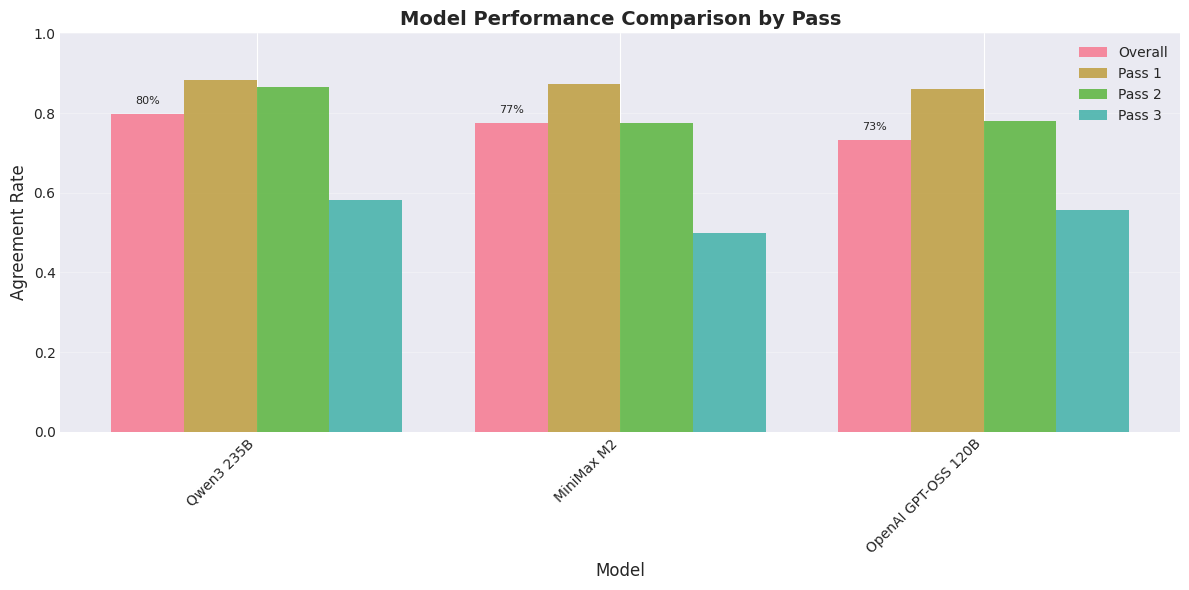

In [91]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(model_performance))
width = 0.2

ax.bar(x - width*1.5, model_performance['avg_agreement'], width, label='Overall', alpha=0.8)
ax.bar(x - width*0.5, model_performance['pass1_agreement'], width, label='Pass 1', alpha=0.8)
ax.bar(x + width*0.5, model_performance['pass2_agreement'], width, label='Pass 2', alpha=0.8)
ax.bar(x + width*1.5, model_performance['pass3_agreement'], width, label='Pass 3', alpha=0.8)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Agreement Rate', fontsize=12)
ax.set_title('Model Performance Comparison by Pass', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_performance['model_name'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1)

# Add value labels on bars
for i, (_, row) in enumerate(model_performance.iterrows()):
    ax.text(i - width*1.5, row['avg_agreement'] + 0.02, f"{row['avg_agreement']:.0%}", 
            ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

### 5.2 Field Type Agreement Heatmap

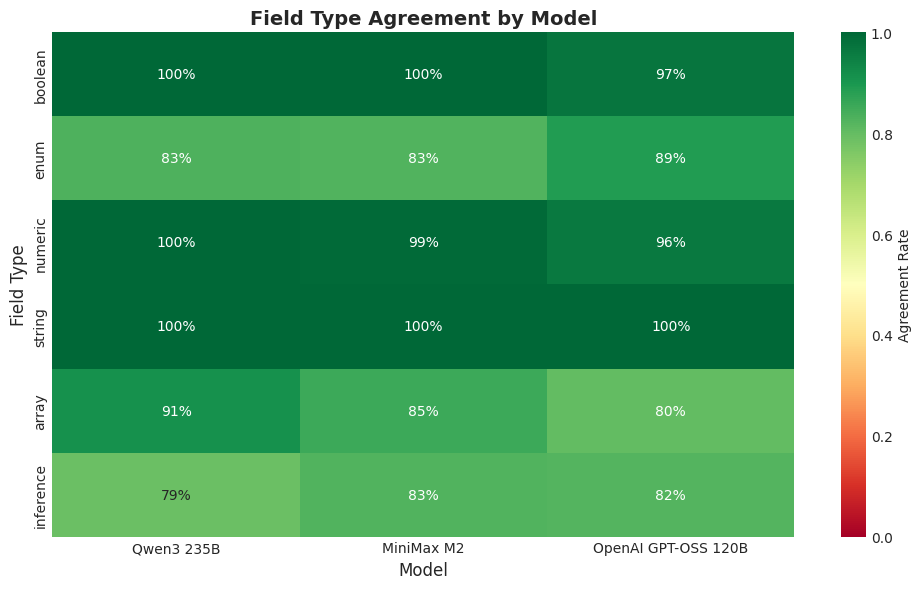

In [92]:
# Build field type x model heatmap
field_type_model_data = defaultdict(lambda: defaultdict(list))

for job_eval in job_evaluations:
    for field_eval in job_eval.field_evaluations:
        ft = field_eval.field_type
        for model_id in job_eval.model_performance.keys():
            # Check if model agrees with consensus
            is_outlier = model_id in field_eval.outlier_models
            field_type_model_data[ft][model_id].append(0 if is_outlier else 1)

# Convert to DataFrame
heatmap_data = []
for ft in field_type_model_data.keys():
    row = {'field_type': ft}
    for model_id in model_performance['model_id']:
        model_name = MODEL_NAMES.get(model_id, model_id)
        agreements = field_type_model_data[ft][model_id]
        row[model_name] = np.mean(agreements) if agreements else 0
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data)
heatmap_df = heatmap_df.set_index('field_type')

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt='.0%', cmap='RdYlGn', vmin=0, vmax=1, 
            cbar_kws={'label': 'Agreement Rate'})
plt.title('Field Type Agreement by Model', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Field Type', fontsize=12)
plt.tight_layout()
plt.show()

### 5.3 Pass-by-Pass Consensus Trends

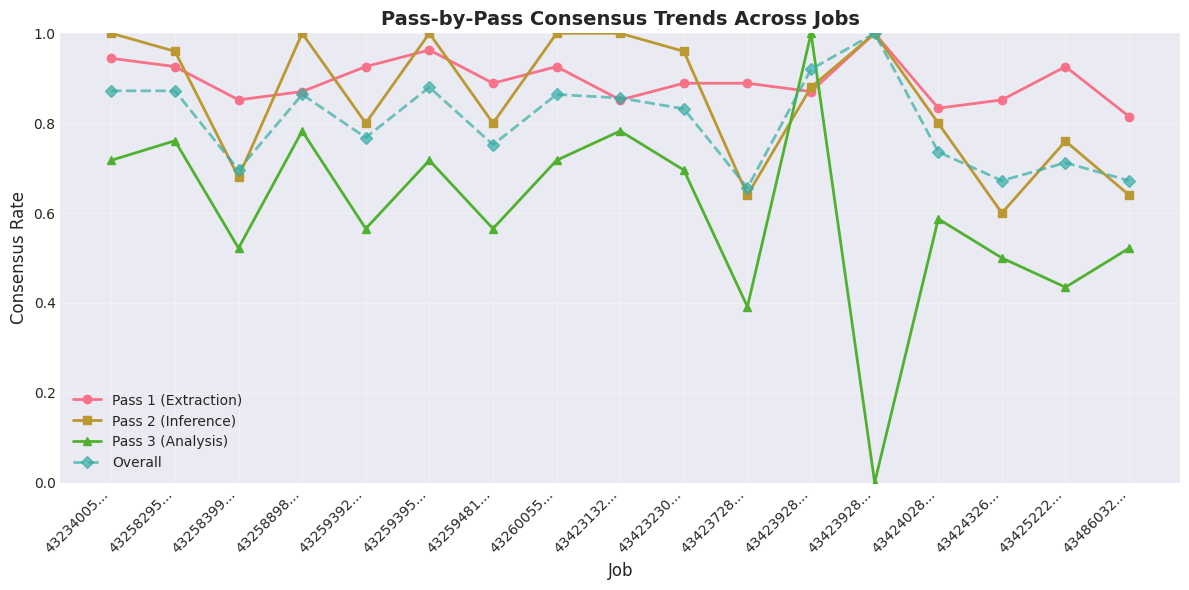

In [93]:
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(pass_trends))
ax.plot(x, pass_trends['pass1_rate'], marker='o', label='Pass 1 (Extraction)', linewidth=2)
ax.plot(x, pass_trends['pass2_rate'], marker='s', label='Pass 2 (Inference)', linewidth=2)
ax.plot(x, pass_trends['pass3_rate'], marker='^', label='Pass 3 (Analysis)', linewidth=2)
ax.plot(x, pass_trends['overall_rate'], marker='D', label='Overall', linewidth=2, linestyle='--', alpha=0.7)

ax.set_xlabel('Job', fontsize=12)
ax.set_ylabel('Consensus Rate', fontsize=12)
ax.set_title('Pass-by-Pass Consensus Trends Across Jobs', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"{row['job_id'][:8]}..." for _, row in pass_trends.iterrows()], rotation=45, ha='right')
ax.legend()
ax.grid(alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

### 5.4 Consensus Distribution

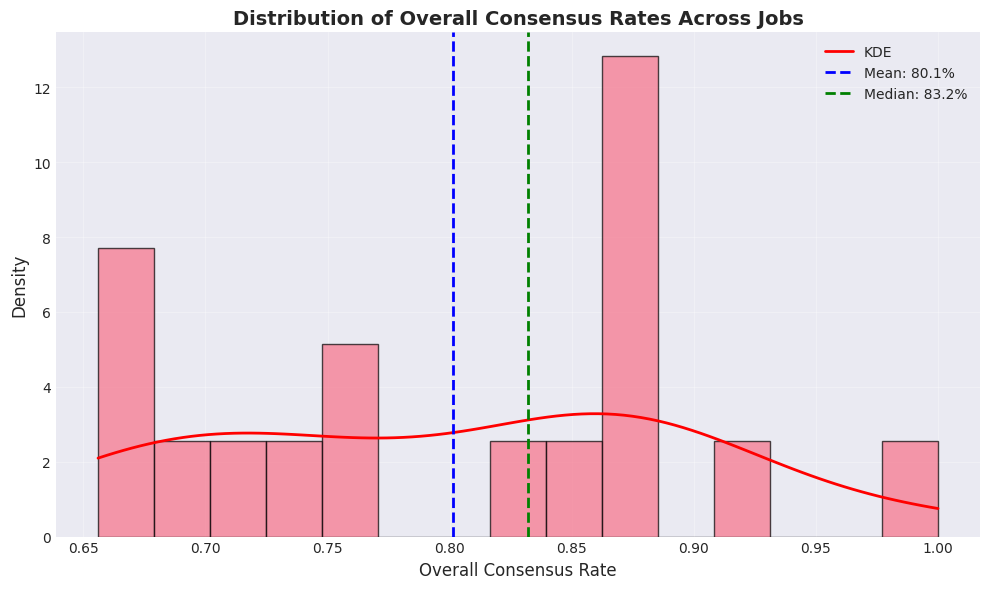

In [94]:
fig, ax = plt.subplots(figsize=(10, 6))

consensus_dist = overall_metrics['consensus_distribution']
ax.hist(consensus_dist, bins=15, alpha=0.7, edgecolor='black', density=True)

# Add KDE
from scipy import stats
if len(consensus_dist) > 1:
    kde = stats.gaussian_kde(consensus_dist)
    x_range = np.linspace(min(consensus_dist), max(consensus_dist), 100)
    ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')

# Add mean and median lines
mean_val = np.mean(consensus_dist)
median_val = np.median(consensus_dist)
ax.axvline(mean_val, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1%}')
ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1%}')

ax.set_xlabel('Overall Consensus Rate', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution of Overall Consensus Rates Across Jobs', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 5.5 Top Low-Agreement Fields

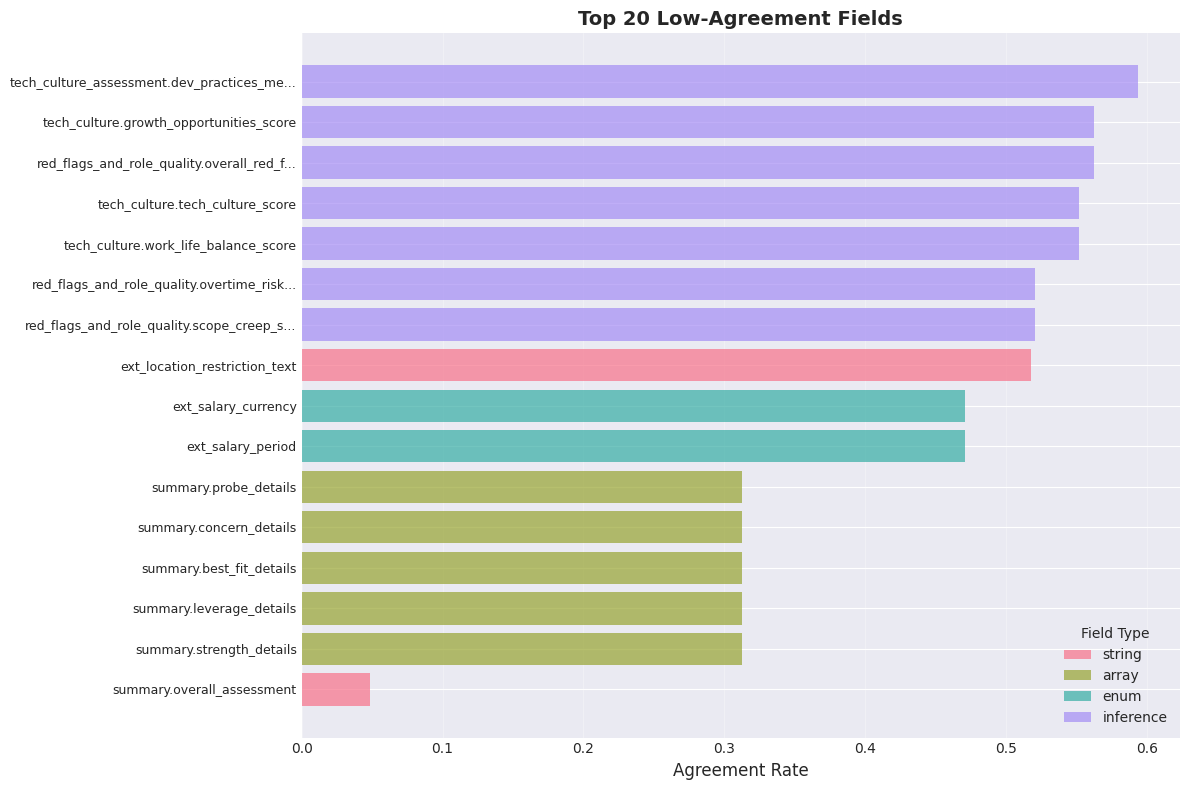

In [95]:
if not low_agreement_fields.empty:
    # Show top 20 worst fields
    top_low = low_agreement_fields.head(20).copy()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create color map by field type
    field_types = top_low['field_type'].unique()
    colors = sns.color_palette('husl', len(field_types))
    color_map = dict(zip(field_types, colors))
    bar_colors = [color_map[ft] for ft in top_low['field_type']]
    
    y_pos = range(len(top_low))
    ax.barh(y_pos, top_low['avg_agreement'], color=bar_colors, alpha=0.7)
    
    # Truncate field names for display
    field_labels = [f[:40] + '...' if len(f) > 40 else f for f in top_low['field_name']]
    ax.set_yticks(y_pos)
    ax.set_yticklabels(field_labels, fontsize=9)
    ax.set_xlabel('Agreement Rate', fontsize=12)
    ax.set_title('Top 20 Low-Agreement Fields', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add legend for field types
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color_map[ft], label=ft, alpha=0.7) for ft in field_types]
    ax.legend(handles=legend_elements, loc='lower right', title='Field Type')
    
    plt.tight_layout()
    plt.show()
else:
    print("No low-agreement fields to visualize")

### 5.6 Model Pairwise Agreement Heatmap

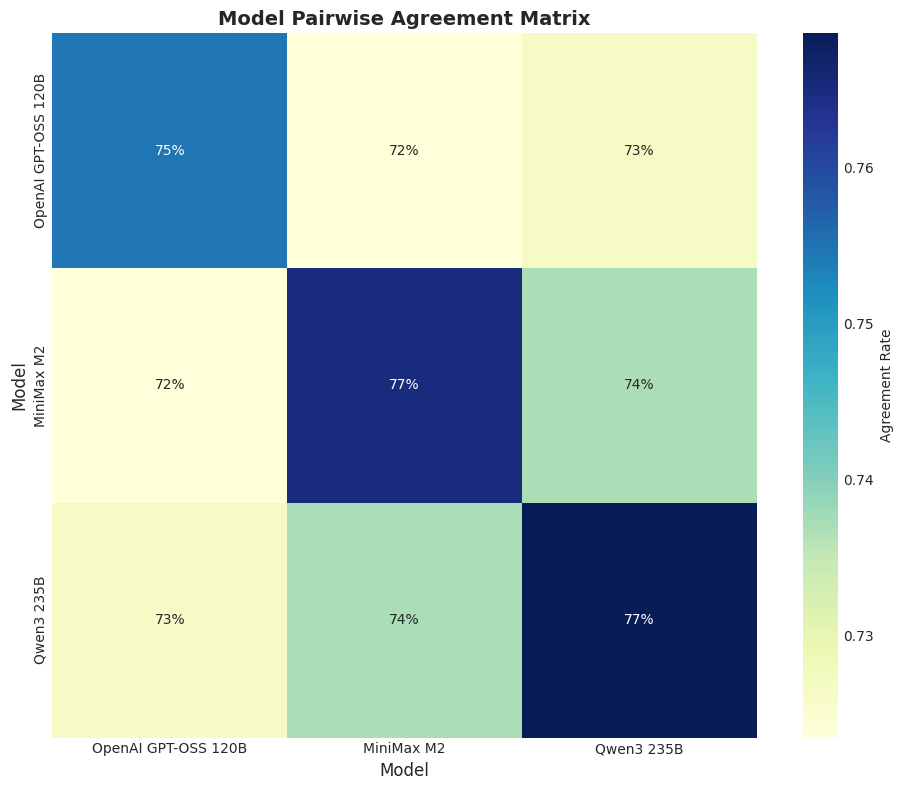

In [96]:
if not model_agreement_matrix.empty:
    plt.figure(figsize=(10, 8))
    sns.heatmap(model_agreement_matrix, annot=True, fmt='.0%', cmap='YlGnBu', 
                square=True, cbar_kws={'label': 'Agreement Rate'})
    plt.title('Model Pairwise Agreement Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot compute model agreement matrix")

### 5.7 Field Type Agreement Distribution (Box Plot)

/tmp/ipykernel_49193/741092645.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


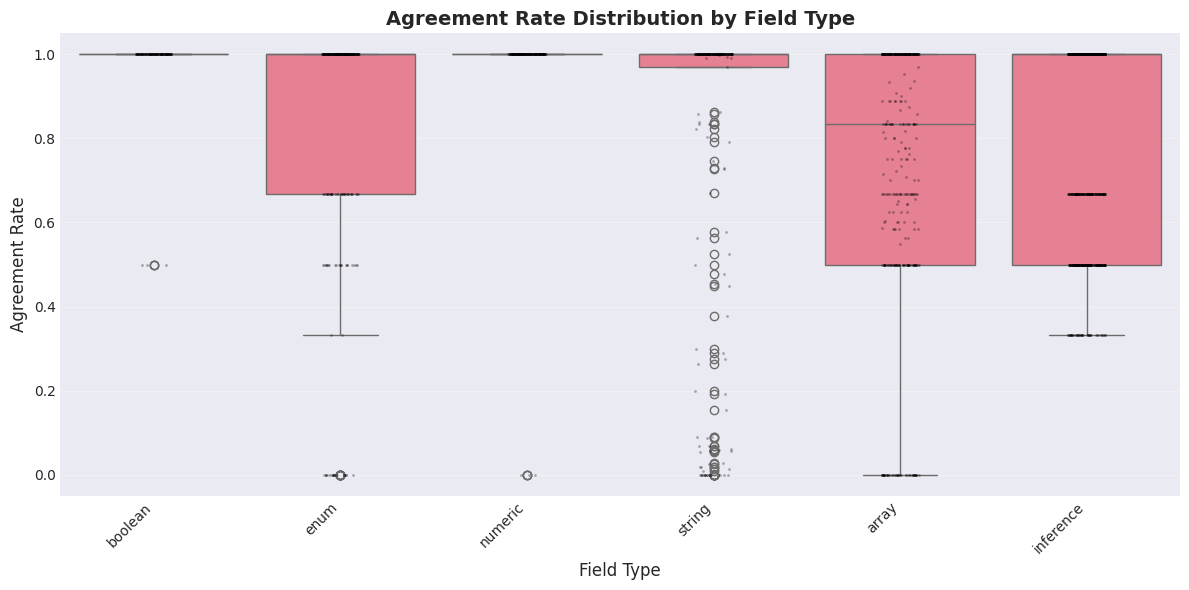

In [97]:
# Collect agreement rates by field type
field_type_distributions = defaultdict(list)

for job_eval in job_evaluations:
    for field_eval in job_eval.field_evaluations:
        field_type_distributions[field_eval.field_type].append(field_eval.agreement_rate)

# Convert to long-form DataFrame for seaborn
box_data = []
for ft, agreements in field_type_distributions.items():
    for agreement in agreements:
        box_data.append({'field_type': ft, 'agreement_rate': agreement})

box_df = pd.DataFrame(box_data)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=box_df, x='field_type', y='agreement_rate', ax=ax)
sns.stripplot(data=box_df, x='field_type', y='agreement_rate', ax=ax, 
              color='black', alpha=0.3, size=2)

ax.set_xlabel('Field Type', fontsize=12)
ax.set_ylabel('Agreement Rate', fontsize=12)
ax.set_title('Agreement Rate Distribution by Field Type', fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 5.8 Job-by-Job Consensus Variation

/tmp/ipykernel_49193/3221993777.py:28: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_49193/3221993777.py:28: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_49193/3221993777.py:28: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/gedalias/data-engineer-jobs/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/gedalias/data-engineer-jobs/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/gedalias/data-engineer-jobs/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning

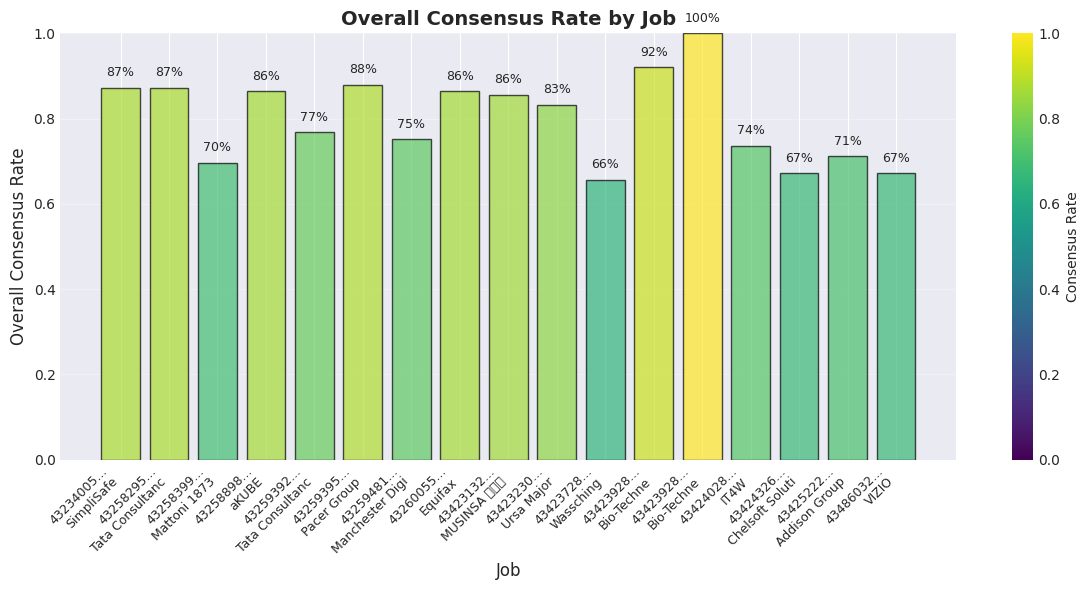

In [98]:
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(pass_trends))
colors = plt.cm.viridis(pass_trends['overall_rate'])

bars = ax.bar(x, pass_trends['overall_rate'], color=colors, alpha=0.7, edgecolor='black')

ax.set_xlabel('Job', fontsize=12)
ax.set_ylabel('Overall Consensus Rate', fontsize=12)
ax.set_title('Overall Consensus Rate by Job', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"{row['job_id'][:8]}...\n{row['company'][:15]}" 
                     for _, row in pass_trends.iterrows()], rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1)

# Add value labels on bars
for i, (_, row) in enumerate(pass_trends.iterrows()):
    ax.text(i, row['overall_rate'] + 0.02, f"{row['overall_rate']:.0%}", 
            ha='center', va='bottom', fontsize=9)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Consensus Rate', fontsize=10)

plt.tight_layout()
plt.show()

## 6. Detailed Drill-Down Tables

### 6.1 All Fields Detail

In [99]:
# Create comprehensive field table
all_fields_data = []

for job_eval in job_evaluations:
    for field_eval in job_eval.field_evaluations:
        all_fields_data.append({
            'job_id': job_eval.job_id,
            'company': job_eval.company_name,
            'field_name': field_eval.field_name,
            'field_type': field_eval.field_type,
            'pass': field_eval.pass_number,
            'has_consensus': field_eval.has_consensus,
            'agreement_rate': field_eval.agreement_rate,
            'outliers': ', '.join(field_eval.outlier_models) if field_eval.outlier_models else 'none'
        })

all_fields_df = pd.DataFrame(all_fields_data)

print(f"\nTotal field evaluations: {len(all_fields_df)}")
print("\nSample of all fields (first 20):")
display(all_fields_df.head(20))

# Can be filtered/sorted interactively
print("\nThis table contains all field evaluations and can be filtered/sorted as needed.")


Total field evaluations: 2079

Sample of all fields (first 20):


,job_id,company,field_name,field_type,pass,has_consensus,agreement_rate,outliers
0,4323400548,SimpliSafe,ext_salary_disclosed,boolean,1,True,1.000000,none
1,4323400548,SimpliSafe,ext_equity_mentioned,boolean,1,True,1.000000,none
2,4323400548,SimpliSafe,ext_learning_budget_mentioned,boolean,1,True,1.000000,none
3,4323400548,SimpliSafe,ext_conference_budget_mentioned,boolean,1,True,1.000000,none
4,4323400548,SimpliSafe,ext_hardware_choice_mentioned,boolean,1,True,1.000000,none
5,4323400548,SimpliSafe,ext_llm_genai_mentioned,boolean,1,True,1.000000,none
6,4323400548,SimpliSafe,ext_feature_store_mentioned,boolean,1,True,1.000000,none
7,4323400548,SimpliSafe,ext_salary_period,enum,1,True,1.000000,none
8,4323400548,SimpliSafe,ext_salary_currency,enum,1,True,1.000000,none
9,4323400548,SimpliSafe,ext_visa_sponsorship_stated,enum,1,True,1.000000,none



This table contains all field evaluations and can be filtered/sorted as needed.


### 6.2 Model Outlier Analysis

In [100]:
# Analyze outlier patterns by model
outlier_data = defaultdict(lambda: defaultdict(int))

for job_eval in job_evaluations:
    for field_eval in job_eval.field_evaluations:
        for outlier_model in field_eval.outlier_models:
            key = f"{field_eval.field_type}|Pass{field_eval.pass_number}"
            outlier_data[outlier_model][key] += 1

# Convert to DataFrame
outlier_rows = []
for model_id, field_type_counts in outlier_data.items():
    for key, count in field_type_counts.items():
        field_type, pass_num = key.split('|')
        outlier_rows.append({
            'model': MODEL_NAMES.get(model_id, model_id),
            'field_type': field_type,
            'pass': pass_num,
            'outlier_count': count
        })

outlier_df = pd.DataFrame(outlier_rows)
if not outlier_df.empty:
    outlier_df = outlier_df.sort_values(['model', 'outlier_count'], ascending=[True, False])

print("\nMODEL OUTLIER ANALYSIS")
print("="*60)
print("Shows how often each model is an outlier by field type and pass")
print("="*60)
display(outlier_df.head(30))


MODEL OUTLIER ANALYSIS
Shows how often each model is an outlier by field type and pass


,model,field_type,pass,outlier_count
2,MiniMax M2,inference,Pass3,90
0,MiniMax M2,enum,Pass1,39
1,MiniMax M2,inference,Pass2,39
3,MiniMax M2,array,Pass3,37
4,MiniMax M2,array,Pass1,12
5,MiniMax M2,numeric,Pass1,1
14,OpenAI GPT-OSS 120B,inference,Pass3,92
15,OpenAI GPT-OSS 120B,array,Pass3,47
13,OpenAI GPT-OSS 120B,inference,Pass2,41
11,OpenAI GPT-OSS 120B,enum,Pass1,25


### 6.3 Per-Job Summary

In [101]:
# Display the pass_trends DataFrame which has per-job summary
print("\nPER-JOB EVALUATION SUMMARY")
print("="*60)

job_summary = pass_trends.copy()
for col in ['pass1_rate', 'pass2_rate', 'pass3_rate', 'overall_rate']:
    job_summary[f"{col}_pct"] = job_summary[col].apply(lambda x: f"{x:.1%}")

display_cols = ['job_id', 'job_title', 'company', 'overall_rate_pct', 
                'pass1_rate_pct', 'pass2_rate_pct', 'pass3_rate_pct']
display(job_summary[display_cols])


PER-JOB EVALUATION SUMMARY


,job_id,job_title,company,overall_rate_pct,pass1_rate_pct,pass2_rate_pct,pass3_rate_pct
0,4323400548,Senior Data Engineer,SimpliSafe,87.2%,94.4%,100.0%,71.7%
1,4325829597,Go Anywhere SFTP Data Engineer,Tata Consultancy Services,87.2%,92.6%,96.0%,76.1%
2,4325839911,AI Data Engineer,Mattoni 1873,69.6%,85.2%,68.0%,52.2%
3,4325889818,Senior Data Engineer – Commerce Data Pipelines,aKUBE,86.4%,87.0%,100.0%,78.3%
4,4325939213,"Senior Data Engineer (SQL, Python, Snowflake)",Tata Consultancy Services,76.8%,92.6%,80.0%,56.5%
5,4325939525,Sr. Data Engineer(hands on Palantir exp.),Pacer Group,88.0%,96.3%,100.0%,71.7%
6,4325948158,Data Engineer,Manchester Digital,75.2%,88.9%,80.0%,56.5%
7,4326005551,Data Engineering USIS,Equifax,86.4%,92.6%,100.0%,71.7%
8,4342313220,Data Engineer (모델링),MUSINSA 무신사,85.6%,85.2%,100.0%,78.3%
9,4342323073,Software & Data Engineer - Palantir Foundry,Ursa Major,83.2%,88.9%,96.0%,69.6%


## 7. Statistical Analysis

### 7.1 Correlation Analysis

In [102]:
from scipy.stats import pearsonr, spearmanr

print("\nCORRELATION ANALYSIS")
print("="*60)

# Correlations between different metrics
correlations = []

# Overall vs Pass rates
for pass_col in ['pass1_rate', 'pass2_rate', 'pass3_rate']:
    r, p = pearsonr(pass_trends['overall_rate'], pass_trends[pass_col])
    correlations.append({
        'metric_1': 'overall_rate',
        'metric_2': pass_col,
        'pearson_r': r,
        'p_value': p,
        'significant': 'Yes' if p < 0.05 else 'No'
    })

# Agreement vs Outlier rate (from model performance)
if len(model_performance) > 1:
    r, p = pearsonr(model_performance['avg_agreement'], model_performance['outlier_rate'])
    correlations.append({
        'metric_1': 'agreement_rate',
        'metric_2': 'outlier_rate',
        'pearson_r': r,
        'p_value': p,
        'significant': 'Yes' if p < 0.05 else 'No'
    })

corr_df = pd.DataFrame(correlations)
display(corr_df)

print("\nInterpretation:")
print("- Strong positive correlation (r > 0.7): Variables move together")
print("- Strong negative correlation (r < -0.7): Variables move opposite")
print("- Weak correlation (-0.3 < r < 0.3): Little linear relationship")


CORRELATION ANALYSIS


,metric_1,metric_2,pearson_r,p_value,significant
0,overall_rate,pass1_rate,0.610830,9.195741e-03,Yes
1,overall_rate,pass2_rate,0.903236,6.827910e-07,Yes
2,overall_rate,pass3_rate,0.196225,4.503603e-01,No
3,agreement_rate,outlier_rate,-0.999892,9.369631e-03,Yes



Interpretation:
- Strong positive correlation (r > 0.7): Variables move together
- Strong negative correlation (r < -0.7): Variables move opposite
- Weak correlation (-0.3 < r < 0.3): Little linear relationship


### 7.2 Field Type Impact

In [103]:
print("\nFIELD TYPE IMPACT ANALYSIS")
print("="*60)
print("Which field types most impact overall consensus?\n")

# Calculate weighted impact (count * avg_agreement)
impact_df = field_type_metrics.copy()
impact_df['impact_score'] = impact_df['total_count'] * impact_df['avg_agreement']
impact_df['weight'] = impact_df['total_count'] / impact_df['total_count'].sum()

impact_df = impact_df.sort_values('impact_score', ascending=False)

display(impact_df[['field_type', 'total_count', 'avg_agreement', 'weight', 'impact_score']])

print("\nInterpretation:")
print("- Impact score = count × avg_agreement")
print("- Higher impact score means field type has more influence on overall consensus")
print("- Weight shows proportion of total fields")


FIELD TYPE IMPACT ANALYSIS
Which field types most impact overall consensus?



,field_type,total_count,avg_agreement,weight,impact_score
5,inference,873,0.812524,0.419913,709.333333
4,array,393,0.738266,0.189033,290.138410
1,enum,272,0.854167,0.130832,232.333333
3,string,237,0.817937,0.113997,193.851079
2,numeric,185,0.983784,0.088985,182.000000
0,boolean,119,0.987395,0.057239,117.500000



Interpretation:
- Impact score = count × avg_agreement
- Higher impact score means field type has more influence on overall consensus
- Weight shows proportion of total fields


### 7.3 Model Specialization

In [104]:
print("\nMODEL SPECIALIZATION BY FIELD TYPE")
print("="*60)
print("Which models excel at which field types?\n")

# Use the heatmap data from visualization 5.2
if not heatmap_df.empty:
    # Find best model for each field type
    best_models = []
    for ft in heatmap_df.index:
        best_model = heatmap_df.loc[ft].idxmax()
        best_score = heatmap_df.loc[ft].max()
        best_models.append({
            'field_type': ft,
            'best_model': best_model,
            'agreement_rate': best_score
        })
    
    specialization_df = pd.DataFrame(best_models)
    specialization_df['agreement_rate'] = specialization_df['agreement_rate'].apply(lambda x: f"{x:.1%}")
    
    display(specialization_df)
    
    print("\nModel Expertise Summary:")
    expertise_count = specialization_df['best_model'].value_counts()
    for model, count in expertise_count.items():
        print(f"  {model}: Best at {count} field type(s)")
else:
    print("Insufficient data for specialization analysis")


MODEL SPECIALIZATION BY FIELD TYPE
Which models excel at which field types?



,field_type,best_model,agreement_rate
0,boolean,Qwen3 235B,100.0%
1,enum,OpenAI GPT-OSS 120B,88.8%
2,numeric,Qwen3 235B,100.0%
3,string,Qwen3 235B,100.0%
4,array,Qwen3 235B,91.2%
5,inference,MiniMax M2,82.6%



Model Expertise Summary:
  Qwen3 235B: Best at 4 field type(s)
  OpenAI GPT-OSS 120B: Best at 1 field type(s)
  MiniMax M2: Best at 1 field type(s)


## 8. Export & Summary

### 8.1 Export Key Tables to CSV

In [ ]:
# Create exports directory if it doesn't exist
export_dir = Path('exports')
export_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Export key tables
exports = {
    'model_performance': model_performance,
    'field_type_metrics': field_type_metrics,
    'low_agreement_fields': low_agreement_fields,
    'high_agreement_fields': high_agreement_fields,
    'pass_trends': pass_trends,
    'all_fields': all_fields_df
}
#
#print("Exporting tables to CSV...")
#for name, df in exports.items():
#    if not df.empty:
##        filepath = export_dir / f"{name}_{timestamp}.csv"
#        df.to_csv(filepath, index=False)
#        print(f"  ✓ Exported: {filepath}")
#
#int(f"\nAll exports saved to: {export_dir}/")

Exporting tables to CSV...
  ✓ Exported: exports/model_performance_20251208_002129.csv
  ✓ Exported: exports/field_type_metrics_20251208_002129.csv
  ✓ Exported: exports/low_agreement_fields_20251208_002129.csv
  ✓ Exported: exports/high_agreement_fields_20251208_002129.csv
  ✓ Exported: exports/pass_trends_20251208_002129.csv
  ✓ Exported: exports/all_fields_20251208_002129.csv

All exports saved to: exports/


### 8.2 Generate Executive Summary

In [106]:
# Generate markdown summary
best_model = model_performance.iloc[0]['model_name']
worst_model = model_performance.iloc[-1]['model_name']
best_field_type = field_type_metrics.iloc[0]['field_type']
worst_field_type = field_type_metrics.iloc[-1]['field_type']

summary_md = f"""
# Inter-Model Evaluation Analysis Summary

**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Overview
- **Jobs Analyzed:** {overall_metrics['total_jobs']}
- **Total Fields Evaluated:** {overall_metrics['total_fields']}
- **Overall Consensus Rate:** {overall_metrics['overall_consensus_rate']:.1%}

## Pass-by-Pass Performance
- **Pass 1 (Extraction):** {overall_metrics['pass1_consensus_rate']:.1%}
- **Pass 2 (Inference):** {overall_metrics['pass2_consensus_rate']:.1%}
- **Pass 3 (Analysis):** {overall_metrics['pass3_consensus_rate']:.1%}

## Key Findings

### Model Performance
- **Best Performer:** {best_model} (Score: {model_performance.iloc[0]['intermodel_score']:.1f})
- **Needs Improvement:** {worst_model} (Score: {model_performance.iloc[-1]['intermodel_score']:.1f})

### Field Type Analysis
- **Highest Agreement:** {best_field_type} ({field_type_metrics.iloc[0]['avg_agreement']:.1%})
- **Lowest Agreement:** {worst_field_type} ({field_type_metrics.iloc[-1]['avg_agreement']:.1%})
- **Gap Fields:** {len(low_agreement_fields)} fields with <60% agreement

### Recommendations
1. **Focus on improving:** {worst_field_type} field types (lowest agreement)
2. **Review models:** Investigate why {worst_model} has lower performance
3. **Address gaps:** Review {len(low_agreement_fields)} low-agreement fields for prompt improvements
4. **Leverage strengths:** {best_model} shows strong performance, consider as reference

## Next Steps
- Review detailed field-level analysis for specific improvements
- Consider adding more models or adjusting prompts for low-agreement fields
- Monitor trends as new jobs are added
"""

# Save summary
summary_path = export_dir / f"executive_summary_{timestamp}.md"
with open(summary_path, 'w') as f:
    f.write(summary_md)

print(f"Executive summary saved to: {summary_path}")
print("\n" + "="*60)
print(summary_md)
print("="*60)

Executive summary saved to: exports/executive_summary_20251208_002129.md


# Inter-Model Evaluation Analysis Summary

**Generated:** 2025-12-08 00:21:29

## Overview
- **Jobs Analyzed:** 17
- **Total Fields Evaluated:** 2079
- **Overall Consensus Rate:** 80.1%

## Pass-by-Pass Performance
- **Pass 1 (Extraction):** 89.5%
- **Pass 2 (Inference):** 85.4%
- **Pass 3 (Analysis):** 60.4%

## Key Findings

### Model Performance
- **Best Performer:** Qwen3 235B (Score: 82.9)
- **Needs Improvement:** OpenAI GPT-OSS 120B (Score: 78.6)

### Field Type Analysis
- **Highest Agreement:** boolean (98.7%)
- **Lowest Agreement:** array (73.8%)
- **Gap Fields:** 16 fields with <60% agreement

### Recommendations
1. **Focus on improving:** array field types (lowest agreement)
2. **Review models:** Investigate why OpenAI GPT-OSS 120B has lower performance
3. **Address gaps:** Review 16 low-agreement fields for prompt improvements
4. **Leverage strengths:** Qwen3 235B shows strong performance, consider as

### 8.3 Key Insights

In [107]:
print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)

insights = []

# Insight 1: Overall performance
if overall_metrics['overall_consensus_rate'] >= 0.8:
    insights.append(f"✓ Strong overall consensus ({overall_metrics['overall_consensus_rate']:.1%}) indicates good model alignment")
elif overall_metrics['overall_consensus_rate'] >= 0.6:
    insights.append(f"⚠ Moderate consensus ({overall_metrics['overall_consensus_rate']:.1%}) - room for improvement")
else:
    insights.append(f"✗ Low consensus ({overall_metrics['overall_consensus_rate']:.1%}) - significant gaps to address")

# Insight 2: Pass variation
pass_rates = [overall_metrics['pass1_consensus_rate'], 
              overall_metrics['pass2_consensus_rate'], 
              overall_metrics['pass3_consensus_rate']]
pass_std = np.std(pass_rates)
if pass_std > 0.15:
    insights.append(f"⚠ High variation between passes (σ={pass_std:.2f}) - some passes need attention")
else:
    insights.append(f"✓ Consistent performance across passes (σ={pass_std:.2f})")

# Insight 3: Model spread
if len(model_performance) > 1:
    score_spread = model_performance['intermodel_score'].max() - model_performance['intermodel_score'].min()
    if score_spread > 10:
        insights.append(f"⚠ Large spread in model scores ({score_spread:.1f} points) - consider model selection")
    else:
        insights.append(f"✓ Models perform similarly (spread: {score_spread:.1f} points)")

# Insight 4: Gap fields
if len(low_agreement_fields) > 0:
    gap_pct = len(low_agreement_fields) / overall_metrics['total_fields'] * 100
    insights.append(f"⚠ {len(low_agreement_fields)} gap fields ({gap_pct:.1f}% of total) need review")
else:
    insights.append("✓ No significant gap fields - strong alignment across all fields")

# Insight 5: Field type challenges
if not field_type_metrics.empty:
    worst_ft = field_type_metrics.iloc[-1]
    if worst_ft['avg_agreement'] < 0.6:
        insights.append(f"⚠ {worst_ft['field_type']} fields are challenging ({worst_ft['avg_agreement']:.1%} agreement)")

for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

print("\n" + "="*60)
print(f"Analysis completed at: {datetime.now()}")
print("="*60)


KEY INSIGHTS
1. ✓ Strong overall consensus (80.1%) indicates good model alignment
2. ✓ Consistent performance across passes (σ=0.13)
3. ✓ Models perform similarly (spread: 4.3 points)
4. ⚠ 16 gap fields (0.8% of total) need review

Analysis completed at: 2025-12-08 00:21:29.534407


---

## Analysis Complete!

This notebook has provided:
- Aggregate metrics across all jobs
- Model performance comparisons
- Field type analysis
- 8 comprehensive visualizations
- Detailed drill-down tables
- Statistical insights
- Exported results to CSV

**Next time you run this notebook:**
- It will automatically discover any new jobs added to `data/local/`
- All metrics and visualizations will update accordingly
- New exports will be timestamped to avoid overwriting
